,A,B,C,D
0,0.658209,0.728953,0.944894,0.611648
1,0.265908,0.890746,0.921383,0.815584
2,0.897606,0.709628,0.675331,0.700544
3,0.225647,0.405564,0.407927,0.530104
4,-0.072632,0.121184,0.379292,0.124129
...,...,...,...,...
996,0.904964,0.930037,1.083495,0.847629
997,0.550649,0.935773,0.720016,0.671166
998,0.330866,0.151832,0.301892,0.312446
999,-0.263318,-0.283540,-0.073638,0.028431


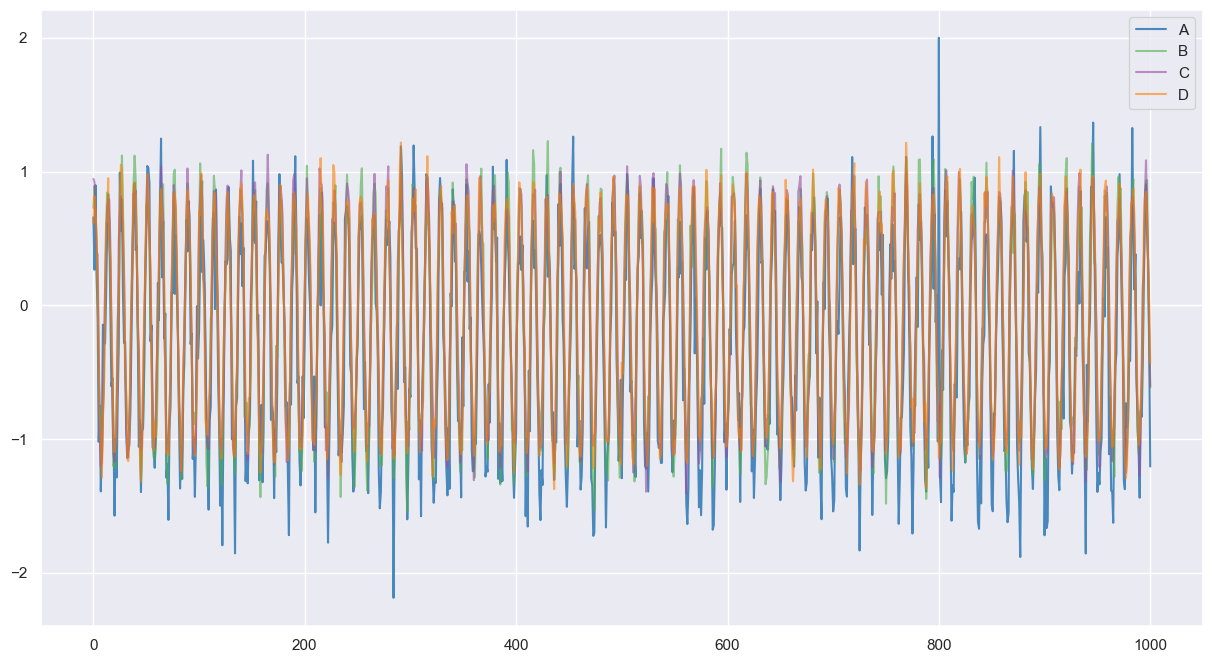

,A,B,C,D
A,1.000000,0.897997,0.910797,0.905892
B,0.897997,1.000000,0.964576,0.964918
C,0.910797,0.964576,1.000000,0.974121
D,0.905892,0.964918,0.974121,1.000000


In [1]:
# パッケージインポート
import os
import re
import collections
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import scipy
import functools
import seaborn as sns
import sys
import tqdm as tq
from tqdm import tqdm
import gzip
import glob
import datetime as dt
import gc
import time
sns.set()

# sin波にランダムにノイズを乗せたデータ4種を生成
x=np.linspace(1,500,1001)
arr = np.random.normal(-0.3, 0.3, len(x))# 乱数
data1=np.sin(x)+arr
arr2 = np.random.normal(-0.16, 0.16, len(x))# 乱数
data2=np.sin(x)+arr2
arr3 = np.random.normal(-0.11, 0.11, len(x))# 乱数
data3=np.sin(x)+arr3
arr4 = np.random.normal(-0.12, 0.12, len(x))# 乱数
data4=np.sin(x)+arr4
data1[800]=2
data=pd.DataFrame(np.hstack((data1.reshape(-1,1),data2.reshape(-1,1),data3.reshape(-1,1),data4.reshape(-1,1))), columns=['A','B','C','D'])
display(data)

colors = list(mpl.cm.Set1.colors)+list(mpl.cm.Set2.colors)+list(mpl.cm.Set3.colors)
fig=plt.figure(figsize=(15,8))
plt.plot(range(len(x)),data1,label='A',alpha=0.9, c=colors[1])
plt.plot(range(len(x)),data2,label='B',alpha=0.6, c=colors[2])
plt.plot(range(len(x)),data3,label='C',alpha=0.6, c=colors[3])
plt.plot(range(len(x)),data4,label='D',alpha=0.6, c=colors[4])
plt.legend()
plt.show()

# A,B,C,Dの相関関係
display(data[['A','B','C','D']].corr())

In [2]:
# 1変数当たりのマハラノビス距離計算
def mahalanobis_list(data):
    # "data" is DataFrame    
    two_data=data.astype(float).values
    two_data_col=data.columns.values
    # 平均
    mean = np.mean(two_data, axis=0)
    # データから平均を引いた値
    two_data_m = two_data - mean
    # 分散共分散行列を計算
    cov = np.cov(two_data.T)
    # 分散共分散行列の逆行列を計算
    cov_i = np.linalg.pinv(cov)

    # distance.mahalanobis
    # データ: two_data[i], 平均値: mean, 共分散行列の逆行列: np.linalg.pinv(cov) から距離を計算
    print('Calculation of Mahalanobis Distance')
    m_d=[(scipy.spatial.distance.mahalanobis(two_data[i], mean, cov_i))/len(two_data_col) for i in tqdm(range(len(two_data)))]

    # SN比解析
    print('Calculation of SN Ratio')
    sn=[]
    for i,row in tqdm(enumerate(two_data_m)):
        xc_prime=two_data_m[i,:]
        SN1=10*np.log10((xc_prime**2)/np.diag(cov))
        sn.append(SN1)

    return np.array(m_d), mean, cov, cov_i, np.array(sn), two_data_col

# Index番号が600までの正常データ
m_d, mean, cov, cov_i, SN1, two_data_col = mahalanobis_list(data.iloc[:600,:])
print('MD shape',m_d.shape)
print('A,B,C,D mean:',mean)
print('A,B,C,D cov:\n',cov)
print('SN ratio shape',SN1.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 33632.01it/s]
600it [00:00, 46214.83it/s]

Calculation of Mahalanobis Distance
Calculation of SN Ratio
MD shape (600,)
A,B,C,D mean: [-0.29291362 -0.14590675 -0.10410803 -0.11798715]
A,B,C,D cov:
 [[0.58449158 0.5111233  0.50320877 0.50417915]
 [0.5111233  0.54374301 0.5095887  0.51252575]
 [0.50320877 0.5095887  0.51326835 0.5021822 ]
 [0.50417915 0.51252575 0.5021822  0.51654244]]
SN ratio shape (600, 4)


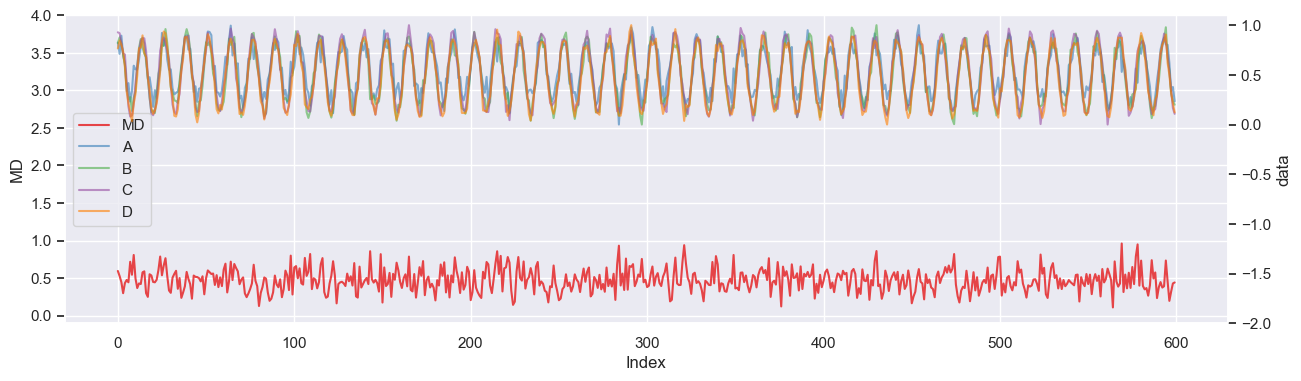

In [3]:
# マハラノビス距離を可視化
colors = list(mpl.cm.Set1.colors)+list(mpl.cm.Set2.colors)+list(mpl.cm.Set3.colors)
plt.figure(figsize=(15,4))
ax=plt.subplot(1,1,1)
ax2=ax.twinx()
train_mean=[]
train_cov=[]
train_cov_i=[]
train_mean.append(mean)
train_cov.append(cov)
train_cov_i.append(cov_i)
ax.plot(data.iloc[:600,:].index, m_d, c=colors[0], alpha=0.8, label='MD')
for j, col_k in enumerate(data.iloc[:600,:].columns.values):
    # plot用に正規化
    mm=MinMaxScaler()
    ax2.plot(data.iloc[:600,:].index, mm.fit_transform(data.iloc[:600,:][col_k].values.reshape(-1,1)), c=colors[j+1], alpha=0.6, label=col_k)
ax.set_ylim(-0.1,4)
ax2.set_ylim(-2,1.1)
ax2.grid(False)
ax.set_xlabel('Index')
ax.set_ylabel('MD')
ax2.set_ylabel('data')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='center left')
plt.show()

In [4]:
# すでに計算した平均や共分散を使ってマハラノビス距離を計算
def mahalanobis_apply(data,mean,cov,cov_i):# mean,cov,cov_iは正常データで求めたもの
    # "data" is DataFrame
    two_data=data.astype(float).values
    two_data_col=data.columns.values
    # データから平均引いた値
    two_data_m = two_data - mean

    # distance.mahalanobis
    # データ: two_data[i], 平均値: mean, 共分散行列の逆行列: np.linalg.pinv(cov) から距離を計算
    print('Calculation of Mahalanobis Distance')
    m_d=[(scipy.spatial.distance.mahalanobis(two_data[i], mean, cov_i))/len(two_data_col) for i in tqdm(range(len(two_data)))]

    # SN比解析
    print('Calculation of SN Ratio')
    sn=[]
    for i,row in tqdm(enumerate(two_data_m)):
        xc_prime=two_data_m[i,:]
        SN1=10*np.log10((xc_prime**2)/np.diag(cov))
        sn.append(SN1)

    return np.array(m_d), np.array(sn), two_data_col

m_d2, SN2, two_data_col2 = mahalanobis_apply(data.iloc[600:,:],train_mean[0],train_cov[0],train_cov_i[0])
print('MD shape',m_d2.shape)
print('SN ratio shape',SN2.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 32208.89it/s]
401it [00:00, 41134.71it/s]

Calculation of Mahalanobis Distance
Calculation of SN Ratio
MD shape (401,)
SN ratio shape (401, 4)


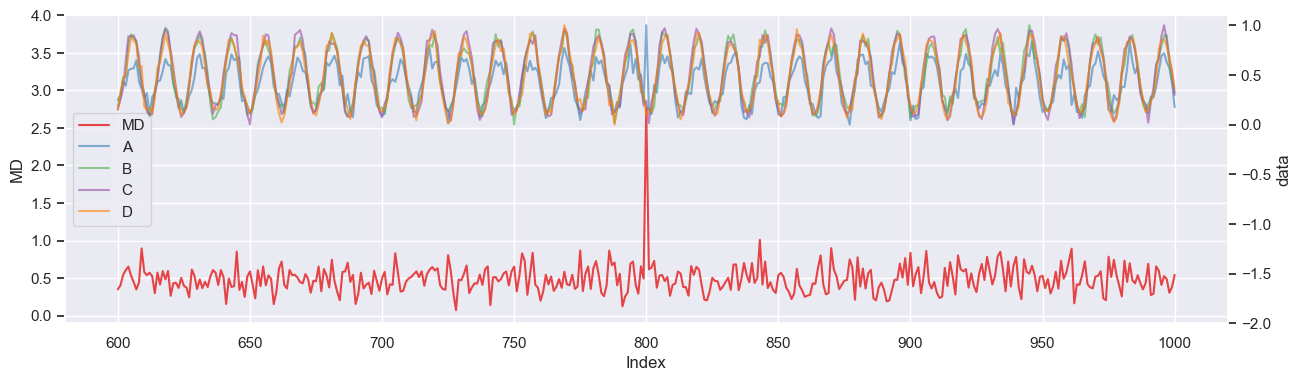

In [5]:
# すでに計算した平均や共分散を使って計算したマハラノビス距離を可視化
plt.figure(figsize=(15,4))
ax=plt.subplot(1,1,1)
ax2=ax.twinx()
ax.plot(data.iloc[600:,:].index, m_d2, c=colors[0], alpha=0.8, label='MD')
for j, col_k in enumerate(data.iloc[:600,:].columns.values):
    # plot用に正規化
    mm=MinMaxScaler()
    ax2.plot(data.iloc[600:,:].index, mm.fit_transform(data.iloc[600:,:][col_k].values.reshape(-1,1)), c=colors[j+1], alpha=0.6, label=col_k)

ax.set_ylim(-0.1,4)
ax2.set_ylim(-2,1.1)
ax.set_xlabel('Index')
ax.set_ylabel('MD')
ax2.set_ylabel('data')
ax2.grid(False)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='center left')
plt.show()

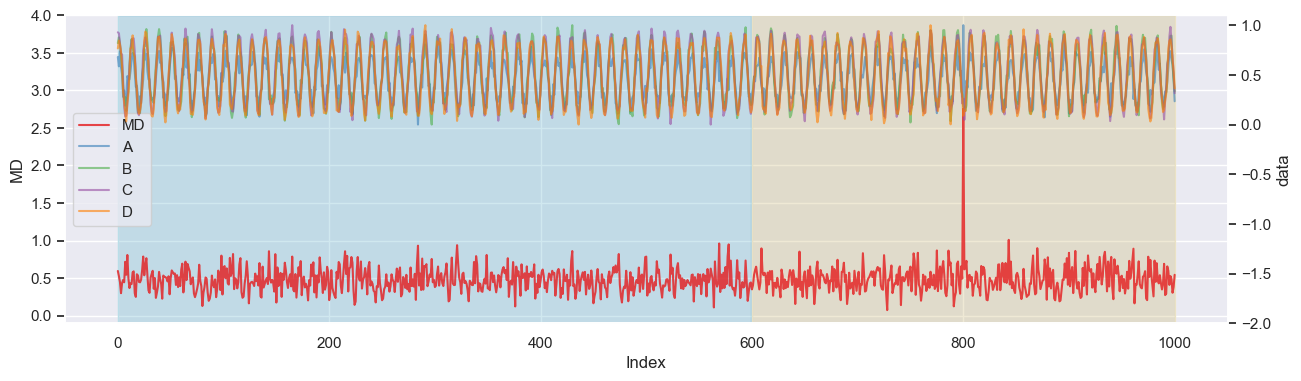

In [6]:
# データを結合
m_d_all=np.hstack((m_d,m_d2))# マハラノビス距離
SN_all=np.vstack((SN1,SN2))# SN比

plt.figure(figsize=(15,4))
ax=plt.subplot(1,1,1)
ax2=ax.twinx()
ax.plot(data.index, m_d_all, c=colors[0], alpha=0.8, label='MD')
for j, col_k in enumerate(data.columns.values):
    # plot用に正規化
    mm=MinMaxScaler()
    ax2.plot(data.index, mm.fit_transform(data[col_k].values.reshape(-1,1)), c=colors[j+1], alpha=0.6, label=col_k)

ax.set_ylim(-0.1,4)
ax2.set_ylim(-2,1.1)
ax2.grid(False)
ax.set_xlabel('Index')
ax.set_ylabel('MD')
ax2.set_ylabel('data')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='center left')
ax.fill_between(data.index[:600], -0.1, 4, color="c", alpha=0.3)
ax.fill_between(data.index[600:], -0.1, 4, color="y", alpha=0.3)
plt.show()

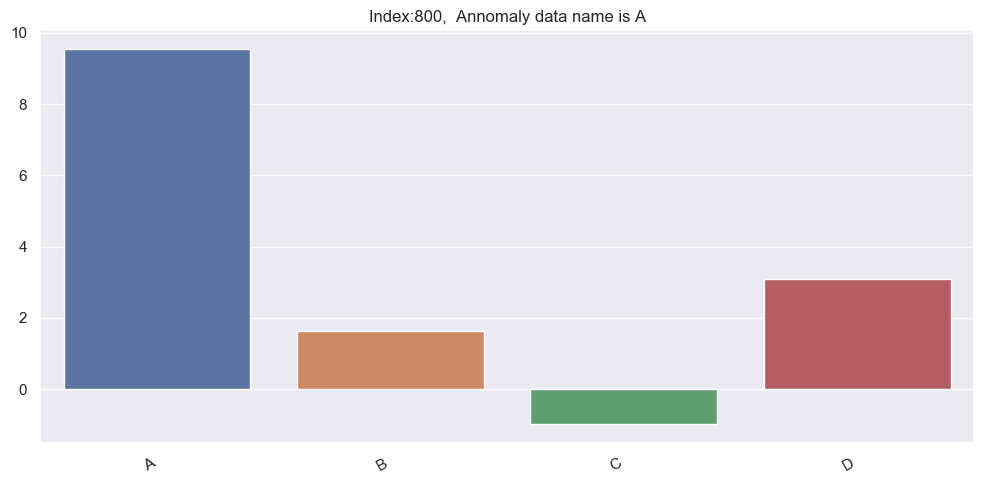

In [7]:
# SN比の可視化
def plot_sn_ratio(two_data_col, inds, SN1, index, figsize=(10,10)):
    plt.figure(figsize=figsize)
    for i, ind in enumerate(inds):
        ax=plt.subplot(int(np.ceil(np.sqrt(len(inds)))),int(np.ceil(np.sqrt(len(inds)))),i+1)
        sns.barplot([two_data_col[i].split('_')[-1] for i in range(len(two_data_col))],SN1[ind,:], ax=ax)
        ax.set_title('Index:'+str(int(index[ind]))+',  Anomaly data name is '+two_data_col[np.argmax(SN1[ind,:])])
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

inds=[800] #inds番目に異常が起きていたindex番号を入れる
plot_sn_ratio(data.columns.values, inds, SN_all, data.index, figsize=(10,5))

In [9]:
# Index番号が600までの正常データ
m_d, mean, cov, cov_i, SN1, two_data_col = mahalanobis_list(data.iloc[:600,:2])
print('MD shape',m_d.shape)
print('A,B mean:',mean)
print('A,B cov:\n',cov)
print('SN ratio shape',SN1.shape)
train_mean=[]
train_cov=[]
train_cov_i=[]
train_mean.append(mean)
train_cov.append(cov)
train_cov_i.append(cov_i)

100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 37597.97it/s]
600it [00:00, 40090.20it/s]

Calculation of Mahalanobis Distance
Calculation of SN Ratio
MD shape (600,)
A,B mean: [-0.29291362 -0.14590675]
A,B cov:
 [[0.58449158 0.5111233 ]
 [0.5111233  0.54374301]]
SN ratio shape (600, 2)


In [10]:
m_d2, SN2, two_data_col2 = mahalanobis_apply(data.iloc[600:,:2],train_mean[0],train_cov[0],train_cov_i[0])
print('MD shape',m_d2.shape)
print('SN ratio shape',SN2.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 26814.55it/s]
401it [00:00, 40201.64it/s]

Calculation of Mahalanobis Distance
Calculation of SN Ratio
MD shape (401,)
SN ratio shape (401, 2)


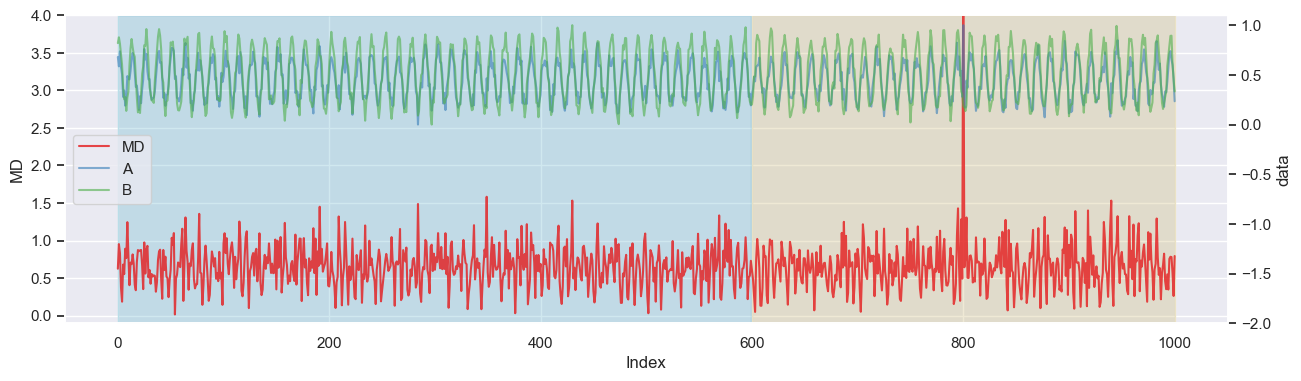

In [11]:
# データを結合
m_d_all=np.hstack((m_d,m_d2))# マハラノビス距離
SN_all=np.vstack((SN1,SN2))# SN比

plt.figure(figsize=(15,4))
ax=plt.subplot(1,1,1)
ax2=ax.twinx()
ax.plot(data.index, m_d_all, c=colors[0], alpha=0.8, label='MD')
for j, col_k in enumerate(data.columns.values[:2]):
    # plot用に正規化
    mm=MinMaxScaler()
    ax2.plot(data.index, mm.fit_transform(data[col_k].values.reshape(-1,1)), c=colors[j+1], alpha=0.6, label=col_k)

ax.set_ylim(-0.1,4)
ax2.set_ylim(-2,1.1)
ax2.grid(False)
ax.set_xlabel('Index')
ax.set_ylabel('MD')
ax2.set_ylabel('data')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='center left')
ax.fill_between(data.index[:600], -0.1, 4, color="c", alpha=0.3)
ax.fill_between(data.index[600:], -0.1, 4, color="y", alpha=0.3)
plt.show()

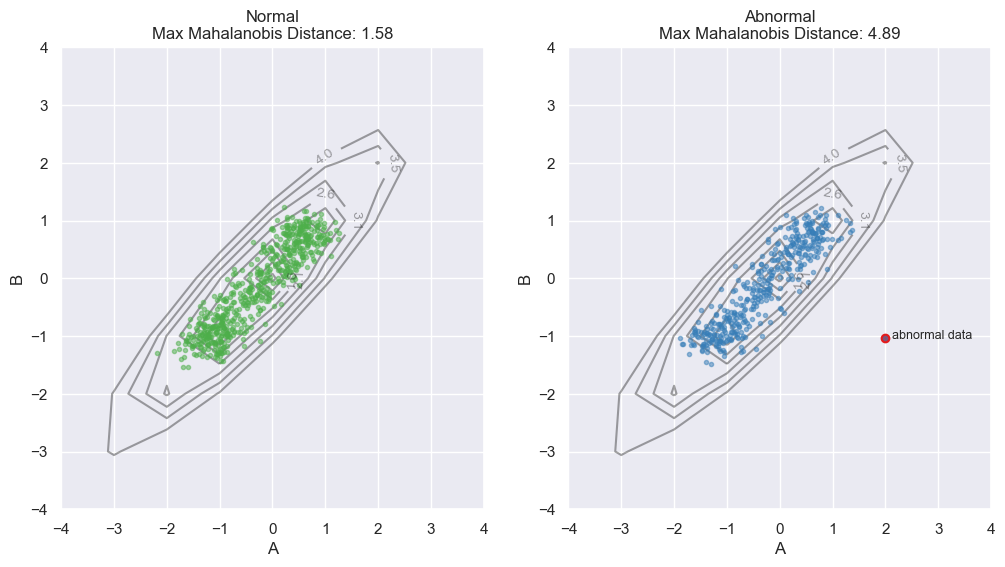

In [62]:
# 2変数の取り得る値とマハラノビス距離の対応を配列として定義
mah_dis=[]
for i in np.round(np.linspace(-4, 4, 18)):
    mah_dis_one=[]
    for j in np.round(np.linspace(-4, 4, 18)):
        mah_dis_one.append((i, j, scipy.spatial.distance.mahalanobis([i,j], mean, cov_i)))
    mah_dis.append(mah_dis_one)
mah_dis=np.array(mah_dis)

# グラフ描画
fig=plt.figure(figsize=(12,6))
colors = list(mpl.cm.Set1.colors)+list(mpl.cm.Set2.colors)+list(mpl.cm.Set3.colors)

ax=plt.subplot(1,2,1)
# 等高線
contour = ax.contour(mah_dis.transpose()[0], mah_dis.transpose()[1], mah_dis.transpose()[2]
                     , levels=np.linspace(-4, 4, 18), colors=['k'],alpha=0.4)
contour.clabel(fmt='%1.1f', fontsize=10)
# 散布図
ax.plot(data.iloc[:600,0].values
        ,data.iloc[:600,1].values
        , '.', color=colors[2], alpha=0.5)
ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])
ax.set_title('Normal\nMax Mahalanobis Distance: '+str(np.round(max(m_d),2)))

ax2=plt.subplot(1,2,2)
# 等高線
contour = ax2.contour(mah_dis.transpose()[0], mah_dis.transpose()[1], mah_dis.transpose()[2]
                      , levels=np.linspace(-4, 4, 18), colors=['k'],alpha=0.4)
contour.clabel(fmt='%1.1f', fontsize=10)
# 散布図
ax2.plot(data.iloc[600:,0].values
        ,data.iloc[600:,1].values
        , '.', color=colors[1], alpha=0.5)
ax2.set_xlabel(data.columns[0])
ax2.set_ylabel(data.columns[1])
ax2.set_title('Abnormal\nMax Mahalanobis Distance: '+str(np.round(max(m_d2),2)))
anom_x=data.iloc[600:,0].values[np.where(m_d2==max(m_d2))[0][0]]
anom_y=data.iloc[600:,1].values[np.where(m_d2==max(m_d2))[0][0]]
ax2.scatter(anom_x
            ,anom_y
            , color=colors[0])
ax2.text(anom_x, anom_y, '  abnormal data', ha='left', fontsize=9)
plt.show()